In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal.windows as windows
import re
import os

from scipy.fft import fft, fftshift, ifft, ifftshift, fftfreq

matplotlib.style.use('bmh')

In [9]:
dir = "/home/mhetu/Desktop/gpr/data/antenna_tests8/"

rx_buffer1_files = [
    "ch1_400_1000_loopback2_270cm.npy"
]

rx_buffer2_files = [
    "ch2_400_1000_loopback2_270cm.npy"
]

dir = "/home/mhetu/Desktop/gpr/uhd_dev/"


/tmp/ipykernel_105510/3588858855.py:67: RuntimeWarning: divide by zero encountered in log10
  mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)


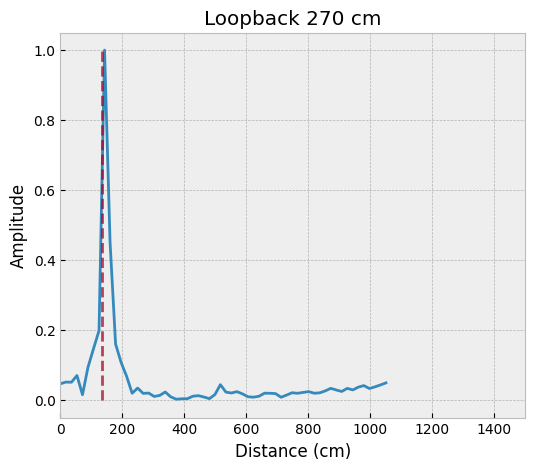

In [14]:
delR = 3e8*0.7/(2*600e6)
maxR = 3e8*0.7/(2*10e6)

x_arr = np.linspace(0, maxR, num=int(maxR/delR))*100

for file1, file2 in zip(rx_buffer1_files, rx_buffer2_files):
    rx_buffer1 = np.load(dir+file2)
    rx_buffer2 = np.load(dir+file1)
    cms = re.search(r'(\d+)cm', file1).group(1)
    
    fs = 20e6 #Sample frequency
    LOs = np.unique(rx_buffer1[:,1]) #The LO values encoded in the output
    nsp = len(LOs) #The number of LO values taken
    Np = min(rx_buffer1[rx_buffer1[:, 1] == LOs[i], 0].shape[0] for i in range(nsp)) #Length of a pulse
    N = len(rx_buffer1) #Length of the full buffer
    N2 = int(N/2) 

    W = windows.tukey(Np)
    Tp = 40001/fs #period for upsampling
    L = (fs)*Tp #Upsampling factor
    Lup = 2*L
    n_zeros = int(Lup/2)
    
    stacklen = N #Taken from the thesis

    #allocate an upsampled stack
    dft_stack = np.zeros(stacklen, dtype = np.complex128)
    
    for i in range(nsp):
    
        # Initializing reference waveform
        ref_chirp = rx_buffer1[rx_buffer1[:,1]==LOs[i], 0][0:N]
        rx_chirp = rx_buffer2[rx_buffer2[:,1]==LOs[i], 0][0:N]
        #plt.plot(fft(ref_chirp))
        #fx = fft(ref_chirp)
        #fx[Np//2: Np] = 0
        #fx[0:Np//2] = fx[0:Np//2]/2
        #plt.plot(fx)
        #plt.plot(fft(np.real(ref_chirp)))
        #plt.show()
        #Take FFTs and use window
        ref_dft = fft(ref_chirp)
        rx_dft = fft(rx_chirp)
    
    
        
        #Compute matched filter
        
        mf_dft = ref_dft * np.conjugate(rx_dft)
        mf_dft = mf_dft*W

        
        #Upsample
        zeros_start = np.zeros(n_zeros) #Upsample by shifting
        zeros_end = np.zeros(stacklen-n_zeros-Np)
        dft_shifted_padded = np.concatenate([zeros_start, mf_dft, zeros_end])

        
        mf_dft_shift = np.roll(dft_shifted_padded, int(i * Np)) #Shift forward to fill the space
        mf_dft_shift = fftshift(mf_dft_shift)
        freqs = fftshift(fftfreq(stacklen, 1/fs))
        
        dft_stack += mf_dft_shift
    #print(dft_stack)


    mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)

    sww = ifftshift(ifft(dft_stack)) #Ifft
    
    p = 20*np.log10(np.abs(sww))
    
    y_arr = np.abs(sww)[int(len(sww)/2):int(len(sww)/2+int(maxR/delR))]
    y_arr /= y_arr.max()

    fig, ax = plt.subplots(figsize = (6,5))

    ax.plot(x_arr, y_arr)
    ax.plot([int(int(cms)/2), int(int(cms)/2)],[0,1], linestyle = '--', alpha=0.75)
    
    ax.set_title(f"Loopback {cms} cm")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Distance (cm)")
    #sample_range = (2.645725e6, 2.645825e6)
    #sample_range = (len(sww)/2+28, len(sww)/2 + 100)
    ax.set_xlim(0, 1500)
    fig.savefig(f'Loopback_{cms}cm.png', dpi=300)
    plt.show()
    